In [1]:
!pip install -i https://pypi.anaconda.org/berber/simple tweet-preprocessor  #remove URLs, hashtags
!pip install wordcloud
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install beautifulsoup4
!pip install textblob
!pip install scikit-learn

Looking in indexes: https://pypi.anaconda.org/berber/simple
  Preparing metadata (setup.py) ... done
  Created wheel for tweet-preprocessor: filename=tweet_preprocessor-0.5.0-py3-none-any.whl size=8038 sha256=5995ef4b9c966c387fe9eedd1b8e769bf7feedc4987226122044d1c73dc19919
  Stored in directory: /root/.cache/pip/wheels/40/e5/f0/f63a5036727aec556c26582a1b867c1c22845f1765b224421c
Successfully built tweet-preprocessor
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 61.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# **Sentiment Analysis**


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
df = pd.read_csv('/content/twitter_sentiment.csv', header=None, index_col=0, on_bad_lines='skip')
df = df[[2, 3]].reset_index(drop=True)
df.columns = ['sentiment', 'text']
df.head()

,sentiment,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75680 entries, 0 to 75679
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  75679 non-null  object
 1   text       74993 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [ ]:
df.isnull().sum()

,0
sentiment,1
text,687


In [ ]:
df.dropna(inplace=True)

In [ ]:
df['sentiment'].value_counts()

,count
sentiment,
Negative,22624
Positive,20932
Neutral,18392
Irrelevant,13045


<Axes: ylabel='count'>

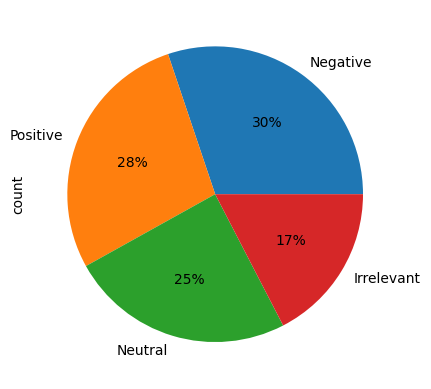

In [ ]:
df['sentiment'].value_counts().plot(kind='pie', autopct='%1.0f%%')

In [ ]:
X=df["text"]
y=df["sentiment"]

In [ ]:
import preprocessor as p
X_preprocessed = X.apply(lambda tweet: p.clean(tweet))

# Hugging Face Transformers using DislitBERT

In [ ]:
from transformers import pipeline

sentiment_analyzer = pipeline("sentiment-analysis")

sentences = []

while True:
    sentence = input("Enter a sentence (or type 'done' to finish): ")
    if sentence.lower() == 'done':
        break
    if sentence.strip():
        sentences.append(sentence.strip())

print("\nSentiment Analysis Results:")
for i, sentence in enumerate(sentences, 1):
    result = sentiment_analyzer(sentence)[0]
    print(f"\nSentence {i}: {sentence}")
    print(f" → Sentiment: {result['label']}, Confidence: {result['score']:.2f}")



No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


Enter a sentence (or type 'done' to finish): i hate twitter 
Enter a sentence (or type 'done' to finish): i love twitter
Enter a sentence (or type 'done' to finish): today is sunny , its a good day
Enter a sentence (or type 'done' to finish): done

Sentiment Analysis Results:

Sentence 1: i hate twitter
 → Sentiment: NEGATIVE, Confidence: 1.00

Sentence 2: i love twitter
 → Sentiment: POSITIVE, Confidence: 1.00

Sentence 3: today is sunny , its a good day
 → Sentiment: POSITIVE, Confidence: 1.00


# RandomForestClassifier

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline


In [ ]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((59994,), (14999,))

In [ ]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
stopwords = list(STOP_WORDS)
clf = Pipeline([('tfidf', TfidfVectorizer(stop_words=stopwords)), ('clf', RandomForestClassifier(n_estimators=100, n_jobs=-1))])
clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['above', 'therein', 'into', 'see',
                                             'of', 'someone', 'quite',
                                             'whenever', 'did', 'becoming',
                                             'anywhere', "'re", 'against',
                                             'sometime', 'because', '’re',
                                             'anyone', 'another', 'whither',
                                             'go', 'as', 'further', 'several',
                                             'on', 'thereupon', 'really',
                                             'call', 'too', 'done', 'hence', ...])),
                ('clf', RandomForestClassifier(n_jobs=-1))])

In [ ]:
# evaluation
from sklearn.metrics import accuracy_score
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.9134608973931595


# Test the Model RandomForest

In [ ]:
new_tweet = input(" write the tweet : ")

cleaned_tweet = p.clean(new_tweet)

prediction = clf.predict([cleaned_tweet])

print(" the expected classification :", prediction[0])

 write the tweet : i hate twitter 
 the expected classification : Negative


# Named Entity Recognition


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

In [ ]:
from transformers import pipeline

ner_pipeline = pipeline("ner", model="dbmdz/bert-large-cased-finetuned-conll03-english")


text = input("أدخل الجملة لتصنيفها: ")


results = ner_pipeline(text)


words = text.split()

for word in words:

    match = [res for res in results if res['word'].lower() == word.lower()]

    if match:

        entity = match[0]['entity']
        confidence = match[0]['score']
        print(f"Word: {word}, Entity: {entity}, Confidence: {confidence:.2f}")
    else:

        print(f"Word: {word}, Entity: O, Confidence: 0.00")

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


أدخل الجملة لتصنيفها: On Wednesday,  Muhammad addressed the annual conference of the International Atomic Energy Agency in North West Frontier Province, Pakistan, while Britain reported the number of marchers as 10,000.
Word: On, Entity: O, Confidence: 0.00
Word: Wednesday,, Entity: O, Confidence: 0.00
Word: Muhammad, Entity: I-PER, Confidence: 1.00
Word: addressed, Entity: O, Confidence: 0.00
Word: the, Entity: O, Confidence: 0.00
Word: annual, Entity: O, Confidence: 0.00
Word: conference, Entity: O, Confidence: 0.00
Word: of, Entity: O, Confidence: 0.00
Word: the, Entity: O, Confidence: 0.00
Word: International, Entity: I-ORG, Confidence: 1.00
Word: Atomic, Entity: I-ORG, Confidence: 1.00
Word: Energy, Entity: I-ORG, Confidence: 1.00
Word: Agency, Entity: I-ORG, Confidence: 1.00
Word: in, Entity: O, Confidence: 0.00
Word: North, Entity: I-LOC, Confidence: 1.00
Word: West, Entity: I-LOC, Confidence: 1.00
Word: Frontier, Entity: I-LOC, Confidence: 1.00
Word: Province,, Entity: O, Confi

# LogisticRegression

In [ ]:

dataset= pd.read_csv("/content/ner_dataset.csv",encoding="latin1" )
dataset.head(30)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [ ]:
dataset =dataset.fillna(method ="ffill")

dataset["Sentence #"] = LabelEncoder().fit_transform(dataset["Sentence #"] )

dataset.dropna(inplace=True)

X = dataset["Word"]
y = dataset['Tag']

<ipython-input-8-4279f5d56780>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataset =dataset.fillna(method ="ffill")


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(encoding='latin-1', ngram_range=(1, 2),stop_words='english')
X_tfidf = tfidf.fit_transform(X)


X_tfidf.shape

(1048575, 30773)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression
regressor = LogisticRegression()
mod = regressor.fit(X_train,y_train)

In [ ]:
from sklearn.metrics import accuracy_score
predictions = mod.predict(X_test)
print(accuracy_score(y_test, predictions))

0.9225043511432182


# Test the model LogisticRegression

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 57.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
text = input("Write the statement: ")

doc = nlp(text)

print("Expected classification:")
for ent in doc.ents:
    print(f"{ent.text} ➜ {ent.label_}")

Write the statement: Thousands of demonstrators marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country.
Expected classification:
Thousands ➜ CARDINAL
London ➜ GPE
Iraq ➜ GPE
British ➜ NORP


# Summarize

# Text summarize using SpaCy

In [ ]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from heapq import nlargest
from collections import Counter

nlp = spacy.load('en_core_web_sm')

def summarize_text(text, num_sentences=3):
    doc = nlp(text)
    tokens = [token.text.lower() for token in doc
              if not token.is_stop and not token.is_punct and token.text != "\n"]

    word_freq = Counter(tokens)
    max_freq = max(word_freq.values())
    for word in word_freq:
        word_freq[word] /= max_freq

    sent_token = [sent.text for sent in doc.sents]
    sent_score = {}

    for sent in sent_token:
        for word in sent.split():
            if word.lower() in word_freq:
                sent_score[sent] = sent_score.get(sent, 0) + word_freq[word.lower()]

    summary_sentences = nlargest(num_sentences, sent_score, key=sent_score.get)
    return ' '.join(summary_sentences)


user_input = input("Enter the text you want to summarize:\n")
summary = summarize_text(user_input)
print("\nSummary:\n", summary)



Enter the text you want to summarize:
 Artificial Intelligence (AI) is transforming the way we live and work. From self-driving cars to smart assistants like Siri and Alexa, AI is becoming an essential part of modern technology. It helps businesses improve customer service, allows doctors to diagnose diseases more accurately, and even helps farmers monitor their crops. As AI continues to grow, it raises important questions about privacy, ethics, and the future of jobs.

Summary:
 It helps businesses improve customer service, allows doctors to diagnose diseases more accurately, and even helps farmers monitor their crops. From self-driving cars to smart assistants like Siri and Alexa, AI is becoming an essential part of modern technology. As AI continues to grow, it raises important questions about privacy, ethics, and the future of jobs.


# Hugging face transformers  BART

In [ ]:
from transformers import pipeline


summarizer = pipeline("summarization", model="facebook/bart-large-cnn")


text = input("Enter the text you want to summarize:\n")


summary = summarizer(text, max_length=100, min_length=30, do_sample=False)

print("\nSummary:\n", summary[0]['summary_text'])


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


Enter the text you want to summarize:
 Artificial Intelligence (AI) is transforming the way we live and work. From self-driving cars to smart assistants like Siri and Alexa, AI is becoming an essential part of modern technology. It helps businesses improve customer service, allows doctors to diagnose diseases more accurately, and even helps farmers monitor their crops. As AI continues to grow, it raises important questions about privacy, ethics, and the future of jobs


Your max_length is set to 100, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)



Summary:
 Artificial Intelligence (AI) is transforming the way we live and work. From self-driving cars to smart assistants like Siri and Alexa, AI is becoming an essential part of modern technology. It raises important questions about privacy, ethics, and the future of jobs.


# **Translation from English to Arabic and vice versa**

# Bidirectional Translation (English ⇄ Arabic) using Seq2Seq with MarianMT - Transformers Library

In [ ]:
from transformers import MarianMTModel, MarianTokenizer


def get_model_for_language(source_lang, target_lang):
    model_name = f"Helsinki-NLP/opus-mt-{source_lang}-{target_lang}"
    model = MarianMTModel.from_pretrained(model_name)
    tokenizer = MarianTokenizer.from_pretrained(model_name)
    return model, tokenizer


def translate(text, model, tokenizer):
    translated = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    translated_output = model.generate(**translated)
    translated_text = tokenizer.decode(translated_output[0], skip_special_tokens=True)
    return translated_text


def select_direction():
    while True:
        print("\nChoose the translation option:")
        print("1. Translate from English to Arabic")
        print("2. Translate from Arabic to English")
        choice = input("Enter 1 or 2: ")

        if choice == '1':
            return 'en', 'ar'
        elif choice == '2':
            return 'ar', 'en'
        else:
            print(" Invalid choice. Please enter 1 or 2.")


source_lang, target_lang = select_direction()
model, tokenizer = get_model_for_language(source_lang, target_lang)
print("\nEnter sentences to translate. Type 'change' to switch direction, or 'stop' to exit.")


while True:
    text = input("> ")

    if text.lower() == 'stop':
        print(" Translation stopped.")
        break
    elif text.lower() == 'change':
        source_lang, target_lang = select_direction()
        model, tokenizer = get_model_for_language(source_lang, target_lang)
        print(" Translation direction changed.")
        continue

    translation = translate(text, model, tokenizer)
    print(f"Original: {text}")
    print(f"Translated: {translation}")





Choose the translation option:
1. Translate from English to Arabic
2. Translate from Arabic to English
Enter 1 or 2: 1

Enter sentences to translate. Type 'change' to switch direction, or 'stop' to exit.
> Hello, how are you?
Original: Hello, how are you?
Translated: مرحباً، كيف حالك؟
> change

Choose the translation option:
1. Translate from English to Arabic
2. Translate from Arabic to English
Enter 1 or 2: 2
✅ Translation direction changed.
> أحب تعلم تقنيات الذكاء الاصطناعي الحديثة لأنها تفتح آفاقًا جديدة وتساعد في حل الكثير من المشكلات في مختلف المجالات.
Original: أحب تعلم تقنيات الذكاء الاصطناعي الحديثة لأنها تفتح آفاقًا جديدة وتساعد في حل الكثير من المشكلات في مختلف المجالات.
Translated: I like to learn modern artificial intelligence techniques because they open up new horizons and help solve a lot of problems in different fields.
> stop
 Translation stopped.
